In [2]:
# download libraries
# ----------
#!pip install scattertext
#!pip install wordcloud
#!pip install textblob

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.2 MB 196.9 kB/s eta 0:00:42
     ---------------------------------------- 0.1/8.2 MB 403.5 kB/s eta 0:00:20
     -- ------------------------------------- 0.5/8.2 MB 2.0 MB/s eta 0:00:04
     ------ --------------------------------- 1.3/8.2 MB 4.3 MB/s eta 0:00:02
     ---------- ----------------------------- 2.1/8.2 MB 6.1 MB/s eta 0:00:02
     ------------- -------------------------- 2.8/8.2 MB 7.3 MB/s eta 0:00:01
     ----------------- ---------------------- 3.6/8.2 MB 8.2 MB/s eta 0:00:01
     ----------------------- ---------------- 4.8/8.2 MB 9.8 MB/s eta 0:00:01
     -----

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 330.3 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/300.2 kB 819.2 kB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.9 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
     - ----------------------------------- 30.7/636.8 kB 262.6 kB/s eta 0:00:03
     ---- -------------------------------- 81.9/636.8 kB 459.5 kB/s eta 0:00:02
     -------------------------- ----------- 440.3/636.8 kB 2.1 MB/s eta 0:00:01
     -------------------------------------- 636.8/636.8 kB 2.9 MB/s eta 0:00:00


In [3]:
# load libraries
# ----------
import pandas as pd
import numpy as np
from PIL import Image
import spacy
import en_core_web_sm
import scattertext as st
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt

# settings 
%matplotlib inline

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [11]:
# load the data
# ----------

# load the dataframe
cfpb = pd.read_csv("D:/HYEM'S/PH.D/Classes/2nd (24.spring)/SOCIOL 273M/handouts/data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])

# identify the unique characters is Product column
cfpb['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Checking or savings account',
       'Money transfer, virtual currency, or money service',
       'Payday loan, title loan, or personal loan',
       'Credit card or prepaid card', 'Mortgage', 'Vehicle loan or lease',
       'Student loan'], dtype=object)

In [12]:
# filter out only columns where product == "Mortgage" or "Student loan"
cfpb = cfpb[(cfpb['Product']=='Mortgage') | (cfpb['Product'] == 'Student loan')]

# subset the first 1000 rows
cfpb = cfpb[:1000]

In [16]:
cfpb.head(n=10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
213,01/20/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,"I have been contacting OCWEN MORTGAGE, PHH MOR...",Company believes it acted appropriately as aut...,Ocwen Financial Corporation,LA,NaN,Servicemember,Consent provided,Web,02/18/20,Closed with explanation,Yes,NaN,3502248
216,01/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,We purchased our house in XX/XX/XXXX the Assig...,NaN,Ocwen Financial Corporation,ID,NaN,NaN,Consent provided,Web,02/10/20,Closed with explanation,Yes,NaN,3497147
283,03/28/20,Mortgage,VA mortgage,Closing on a mortgage,NaN,I had past issues with Mortgage Solutions of C...,NaN,MORTGAGE SOLUTIONS OF COLORADO,TX,NaN,Servicemember,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3583812
293,03/31/20,Mortgage,VA mortgage,Trouble during payment process,NaN,I have called Nationstar multiple times to req...,Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE,MN,551XX,Servicemember,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586865
387,03/31/20,Mortgage,VA mortgage,Struggling to pay mortgage,NaN,All documents for the short sale review were s...,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",VA,NaN,NaN,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3588118
397,04/01/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,"On XX/XX/2020, the CARES Act was signed into f...",NaN,AES/PHEAA,VA,223XX,NaN,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3587932
403,04/02/20,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,- XX/XX/XXXX Got a letter my property taxes we...,Company believes complaint represents an oppor...,Ocwen Financial Corporation,WI,NaN,NaN,Consent provided,Web,04/02/20,Closed with explanation,Yes,NaN,3589531
407,04/03/20,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,XXXX XXXX Loan care servicing took over my loa...,Company has responded to the consumer and the ...,"LoanCare, LLC",GA,300XX,NaN,Consent provided,Web,04/03/20,Closed with explanation,Yes,NaN,3592305
490,03/03/20,Mortgage,FHA mortgage,Struggling to pay mortgage,NaN,Mr. XXXX provided a reinstatement quote in the...,Company has responded to the consumer and the ...,Freedom Mortgage Company,GA,303XX,NaN,Consent provided,Web,03/03/20,Closed with explanation,Yes,NaN,3552432
546,05/11/20,Mortgage,Home equity loan or line of credit (HELOC),Struggling to pay mortgage,NaN,Specialized Loan Servicing Crooks ... .. My hu...,Company has responded to the consumer and the ...,Specialized Loan Servicing Holdings LLC,TN,370XX,Older American,Consent provided,Web,05/11/20,Closed with explanation,Yes,NaN,3646965


In [64]:
# create preprocessing function - just like we did in the last lab
# ----------
def rem_punc_stop(text):

    # set objects
    stop_words = STOP_WORDS         # set STOP_WORDS to a new object variable
    punc = set(punctuation)         # convert punctuation to a set
    
    text_lower = text.lower()
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text_lower if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension
    

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
     
     
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    # return
    return no_punc

In [65]:
# now apply the function to all the columns in our dataframe
# ----------
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x)) # can use apply here 
cfpb['tokens'] # visualize

213      [contacting, ocwen, mortgage, phh, mortgage, x...
216      [purchased, house, xxxxxxxx, assignment, deed,...
283      [past, issues, mortgage, solutions, colorado, ...
293      [called, nationstar, multiple, times, request,...
387      [documents, short, sale, review, sent, xxxx20,...
                               ...                        
33836    [contacted, xxxx, xxxx, offering, complete, ap...
33855    [parent, plus, loan, opened, xxxxxxxx, childre...
33860    [tcf, refusing, provide, account, information,...
33880    [asking, loan, modification, years, particular...
33896    [loan, bayview, loan, services, went, 3,  , xx...
Name: tokens, Length: 1000, dtype: object

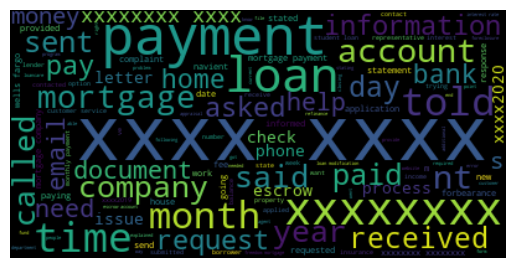

In [66]:
# now apply the function to all the columns in our dataframe
# ----------
# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(random_state=40).generate(text) # set random state to ensure same word cloud each time

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

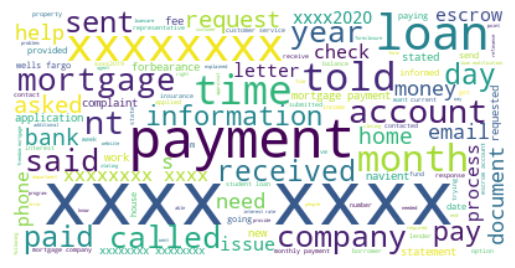

In [67]:
# same word cloud as above but changing background parameters
# ----------
# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # set background color to white
                      random_state=41              # set random state to ensure same word cloud each time
                      ).generate(text)             # change the background color


# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

In [73]:
# rewrite the rem_punc_stop function to remove redacted account numbers (e.g, "XXX")
# ----------

def rem_punc_stop(text):
    stop_words = STOP_WORDS

    #########################################
    # individually
    # ----------
    # nlp.Defaults.stop_words.add("XX")
    # nlp.Defaults.stop_words.add("XXXX")
    # nlp.Defaults.stop_words.add("XXXXXXX")
    
    # all at once
    # ----------
    #nlp.Defaults.stop_words.update({"XX", "XXXX","XXXXXXXX"})
    
    # more eloquent manner
    # ----------
    # |= operator is called the "in-place OR" or "bitwise OR assignment" operator
    # When used with sets, it performs an in-place union operation, updating the 
    # set on the left with the union of itself and the set on the right.
    #########################################
    
    # remove stop words
    nlp.Defaults.stop_words |= {"xx", "xxxx","xxxxxxxx"}
    
    # convert punctuation to set
    punc = set(punctuation)
    text_lower = text.lower()
    
    # essentially remove the punctuation - important to remove punctuation first to correctly capture stop words
    punc_free = "".join([ch for ch in text_lower if ch not in punc]) # join new list of characters (ch) in text w/ condition
                                                               # if ch is not in punctuation 
                                                               # "".join() creates a string from the list comprehension

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # extract words from processed text 
    spacy_words = [token.text for token in doc]
    
    # filter out words 
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    # return
    return no_punc

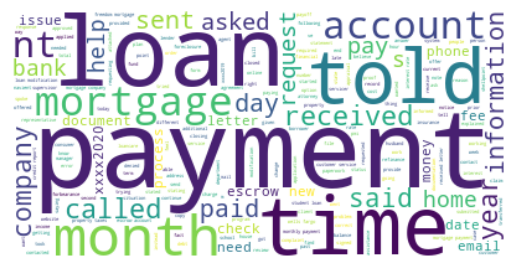

In [74]:
# recreate word cloud from above 
# ----------
# need to do preprocessing again and re-create "tokens" column
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))

# apply function to text object
text = ' '.join(cfpb['tokens'].map(lambda text: ' '.join(text)))

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color = "white",  # specify white background
                     random_state=42               # set random state to ensure same word cloud
                     ).generate(text)              # generate from text dataset

# plot 
plt.imshow(wordcloud,                  # specify wordcloud
           interpolation = 'bilinear') # specifies how the words are displayed
plt.axis('off')                        # turn off axes
plt.show()                             # show the plot

In [78]:
# create a feature colum of sentiment polarity
# ---------- 
# create the "tokens" column again 
cfpb['tokens'] = cfpb['tokens'].map(lambda text: ' '.join(text))

# create the "tokens" column again 
cfpb['polarity'] = cfpb['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

# view
cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,tokens,polarity
213,01/20/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,"I have been contacting OCWEN MORTGAGE, PHH MOR...",Company believes it acted appropriately as aut...,Ocwen Financial Corporation,LA,NaN,Servicemember,Consent provided,Web,02/18/20,Closed with explanation,Yes,NaN,3502248,contacting ocwen mortgage phh mortgage avail e...,0.078333
216,01/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,We purchased our house in XX/XX/XXXX the Assig...,NaN,Ocwen Financial Corporation,ID,NaN,NaN,Consent provided,Web,02/10/20,Closed with explanation,Yes,NaN,3497147,purchased house assignment deed trust signed r...,0.092857
283,03/28/20,Mortgage,VA mortgage,Closing on a mortgage,NaN,I had past issues with Mortgage Solutions of C...,NaN,MORTGAGE SOLUTIONS OF COLORADO,TX,NaN,Servicemember,Consent provided,Web,04/01/20,Closed with explanation,Yes,NaN,3583812,past issues mortgage solutions colorado llc sp...,0.151667
293,03/31/20,Mortgage,VA mortgage,Trouble during payment process,NaN,I have called Nationstar multiple times to req...,Company believes it acted appropriately as aut...,NATIONSTAR MORTGAGE,MN,551XX,Servicemember,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3586865,called nationstar multiple times request updat...,0.050000
387,03/31/20,Mortgage,VA mortgage,Struggling to pay mortgage,NaN,All documents for the short sale review were s...,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",VA,NaN,NaN,Consent provided,Web,03/31/20,Closed with explanation,Yes,NaN,3588118,documents short sale review sent xxxx20 shellp...,0.362500


D:\Program\ANACONDA\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


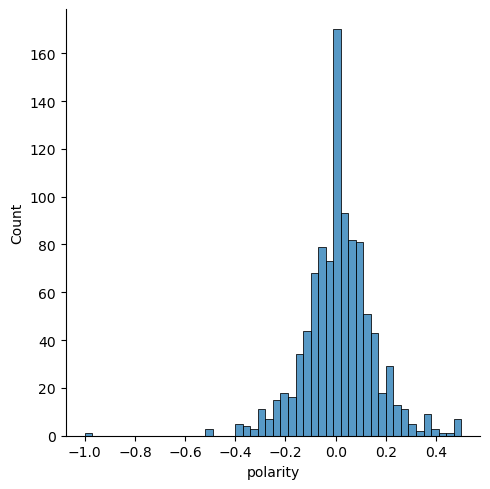

In [79]:
# histogram of polarity
sns.displot(cfpb,         # specify data
            x="polarity") # x-axis label 
plt.show()

In [90]:
# loop to view the 5 most negative reviews
# ---------- 
for complaint in cfpb.nlargest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + '\n')

the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes

I paid my XXXX mortgage with Bayview Loan Servicing LLC. I have a confirmation number for my payment, and my payment came out of my bank account. My agent said that a mistake had been made and that my account had been sent to foreclosure, but he took my payment anyway. He assured me, though, that he would contact his supervisor and have the process halted. This morning a woman and knocked on my door saying she represented a third-party and that my home was in foreclosure and she was doing an occupancy check. I contacted XXXX XXXX. XXXX said that Bayview is in the business of foreclosing on homes. I want to be placed with a more reputable mortgage company. You can not eve

In [1]:
# K-means clustering
# ------------------------------

# implement kmeans clustering
# ----------
kmeans = KMeans(n_clusters=3,   
                max_iter=300    
                ).fit(tfidf_matrix) # specify data to fit

# append labels to dataframe
# ----------
cfpb['cluster']= kmeans.labels_    # add labels to original data frame
cfpb.head()

NameError: name 'KMeans' is not defined